In [ ]:
import numpy as np
import scipy.optimize as sciopt
import scipy.stats as scistats
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt

# Вспоминаем и совершенствуем методологию ММП

## Модель независимых наблюдений

### Модель

Для примера рассмотрим гауссовскую выборку.

$X_i \overset{iid}{\sim} \mathcal{N}(\mu, \sigma^2)$

### Параметры

$\theta = (\mu, \sigma^2)$

### Выборка

$\{x_i\}_{i=1}^{n}$, где $x_i$ - реализация случайной величины $X_i$.  

Не забываем, что данные случайные, оценка параметров тоже случайная, но если выборка дана, оценка может быть вычислена по ней.

### Правдоподобие

Независимость наблюдений позволяет разложить совместную плотность в произведение плотностей, после логарифмирования получим лог-правдоподобие в виде суммы логарифмов:

$L(\theta) = p_{\theta}(x_1, ..., x_n) = \prod \limits_{i=1}^{n} p_{\mathcal{N}( \mu, \sigma^2)}(x_i)  = \prod \limits_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma^2 }} \exp \bigl[ - \frac{(x_i - \mu)^2}{2 \sigma^2}\bigr]$

$l(\theta) = \sum \limits_{i=1}^{n} \ln p_{\mathcal{N}( \mu, \sigma^2)}(x_i)
= - \frac{n}{2} \ln (2 \pi \sigma^2) - \sum \limits_{i=1}^n \frac{(x_i - \mu)^2}{2 \sigma^2}$

### ММП-оценки

$l'_{\mu} = - \sum \limits_{i=1}^n \frac{- 2 (x_i - \mu)}{2 \sigma^2} = 0$

Из этого условия получаем $\mu = \frac{1}{n} \sum \limits_{i=1}^n x_i$.


$l'_{\sigma^2} = - \frac{n}{2} \frac{1}{\sigma^2}  + \frac{1}{2 \sigma^4} \sum \limits_{i=1}^n (x_i - \mu)^2 = 0$


Отсюда $\sigma^2 = \frac{1}{n} \sum \limits_{i=1}^n (x_i - \mu)^2$.

Поскольку формально это не истинные параметры, а их оценки (они зависят от выборки), то обычно вместо $\mu, \sigma^2$ пишут $\hat{\mu}, \hat{\sigma}^2$, про это нельзя забывать.

Можно проверить условие второго порядка, вы справитесь, мы в вас верим.

### Оценка одномерной выборки

Проверим формулы на примере.

In [ ]:
size = 10000 # Number of observations
mu = 3 # Mean
sigma = 2 # Standard deviation
sample = np.random.normal(loc=mu, scale=sigma, size=size)

### Явное решение

In [ ]:
mu_hat = sample.mean()
sigma_hat = np.sqrt(
        np.sum(
            (sample - sample.mean())**2
        )
        / size
    )

print(f"Estimated mu: {mu_hat}")
print(f"Estimated sigma: {sigma_hat}")

Estimated mu: 2.980444907936079
Estimated sigma: 1.9925292095309364


### Численное решение

В более сложных случаях можно пробовать численно, ниже показано как. В нашем очень простом случае мы имеем возможность сравнить резульаты.

In [ ]:

def log_likelihood_factory(sample: np.ndarray):

    def log_likelihood(params):
        mu, sigma = params

        n = len(sample)

        lik =   - 0.5 * n * np.log(2 * np.pi) \
                - 0.5 * n * np.log(sigma ** 2) \
                - (0.5 / sigma **2) * np.sum(
                (sample - mu)**2
            )

        # For maximization
        return  - lik

    return log_likelihood


def log_likelihood_grad_factory(sample: np.ndarray):

    def log_likelihood_grad(params):
        mu, sigma = params

        n = len(sample)

        mu_part =  (1 / sigma **2) * (np.sum(sample) - n * mu)
        sigma_part =  (0.5 / sigma **2) \
                        *  ((1 / sigma **2) *np.sum((sample - mu)**2) - n)

        # For maximization
        return - np.array([mu_part, sigma_part])

    return log_likelihood_grad

In [ ]:
x0 = np.random.uniform(size=2)
res = sciopt.minimize(
    log_likelihood_factory(sample),
    x0,
    jac=log_likelihood_grad_factory(sample)
)

In [ ]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 21083.43324518944
        x: [ 2.980e+00  1.993e+00]
      nit: 17
      jac: [-7.553e-06 -1.857e-06]
 hess_inv: [[ 3.845e-04 -6.141e-06]
            [-6.141e-06  7.881e-04]]
     nfev: 22
     njev: 22

## Авторегрессия

Авторегрессия порядка $p$ также обозначается $AR(p)$, известная и хорошо исследованная модель временных рядов, для нас это первый несложный пример выборки из зависимых наблюдений, а ещё -- база для понимания механизма тех моделей, что мы увидим далее.

### Модель

$X_0 = x_0 = const$

$X_{i+1} = \alpha \cdot X_i + \epsilon_{i+1} $

$\epsilon_i \overset{iid}{\sim}  \mathcal{N}(0, \sigma^2)$


### Параметры

$\theta = (\alpha, \sigma^2)$ и $x_0$ обычно полагается равным первому известному наблюдению, либо задаётся априорным распределением (в байесовском подходе). Мы примем первый вариант, оказывается он тоже может быть обоснован с точки зрения гауссовского априорного распределения для $X_0$.

### Выборка

$\{x_i\}_{i=0}^{n}$, где $x_i$ - реализация случайной величины $X_i$

$\hat{\epsilon}_i =x_{i} - \alpha x_{i-1}$

### Правдоподобие

$X_{i+1} = \alpha \cdot X_i + \epsilon_{i+1}, \quad X_{i+1} | X_i \sim \mathcal{N}(\alpha X_i, \sigma^2)$


$L(\theta) = p_{\theta}(x_1, ..., x_n) = p_{\theta}(x_1) p_{\theta}(x_2 | x_1) ... p_{\theta}(x_n | x_{n-1}, ... x_1)  = \prod \limits_{i=1}^n p_{\theta}(x_i | x_{i-1}) = \prod \limits_{i=1}^n p_{\mathcal{N}(\alpha x_{i-1}, \sigma^2)}(x_i)$

$L(\theta) = p_{\theta}(\hat{\epsilon}_1, ..., \hat{\epsilon}_n) = \prod \limits_{i=1}^n p_{\theta}(\hat{\epsilon}_i)  = \prod \limits_{i=1}^n p_{\mathcal{N}(0, \sigma^2)}(x_i - \alpha x_{i-1})$

$l(\theta) = - \frac{n}{2} \ln (2 \pi \sigma^2) - \sum \limits_{i=1}^n \frac{(x_i - \alpha \cdot x_{i-1})^2}{2 \sigma^2} =  - \frac{n}{2} \ln (2 \pi \sigma^2) - \sum \limits_{i=1}^n \frac{x_i ^2  - 2\alpha \cdot x_i x_{i-1} + (\alpha \cdot x_{i-1})^2}{2 \sigma^2}$

Как вы думаете, почему в условной вероятности можно убрать все наблюдения в условии кроме самого нового?

<details>

<summary>Спойлер</summary>
Это можно проверить, выписав $X_i$ в виде суммы шумов и сопоставив с другими $X_j$.
</details>

### ММП-оценки


$l'_{\alpha} =  - \sum \limits_{i=1}^n \frac{ - 2 \cdot x_i x_{i-1} + 2\alpha \cdot x_{i-1}^2}{2 \sigma^2}
= -\frac{1}{ \sigma^2} [ - \sum \limits_{i=1}^n x_i x_{i-1} + \alpha \cdot \sum \limits_{i=1}^n x_{i-1}^2 ]= 0$

$\hat{\alpha}_{MLE} = \frac{\sum \limits_{i=1}^n x_i x_{i-1} }{ \sum \limits_{i=1}^n x_{i-1}^2}$

$l'_{\sigma^2} = - \frac{n}{2} \frac{1}{\sigma^2}  + \frac{1}{2\sigma^4} \sum \limits_{i=1}^n (x_i - \alpha \cdot x_{i-1})^2 = 0$

$\hat{\sigma}^2_{MLE} = \frac{1}{n} \sum \limits_{i=1}^n (x_i - \hat{\alpha} \cdot x_{i-1})^2$

In [ ]:
class AR_MLE:
    """
    Класс авторегрессионной модели (AR(1)) с аналитической оценкой
    параметров методом максимального правдоподобия (MLE).
    """
    def __init__(self, p: int):
        """
        Инициализирует модель с заданным порядком (p).

        Args:
            p (int): Порядок авторегрессии. Должен быть 1 для этого класса.
        """
        if p != 1:
            raise ValueError("Этот класс предназначен только для модели AR(1).")
        self.p = p
        self.coefficients = None
        self.sigma2 = None  # Дисперсия шума
        self.fitted_data = None
        self.training_history = None # Данные, использованные для обучения
        self.full_history = None # Полные исходные данные

    def sample(self, coefficients: np.ndarray, length: int, initial_values: np.ndarray = None, std_dev: float = 1.0) -> np.ndarray:
        """
        Генерирует выборку данных из модели AR(1) с заданными коэффициентами (без константы).

        Args:
            coefficients (np.ndarray): Коэффициенты модели.
            length (int): Длина сгенерированного временного ряда.
            initial_values (np.ndarray, optional): Начальные значения для ряда.
                Если не предоставлены, используются случайные значения.
            std_dev (float, optional): Стандартное отклонение шума.

        Returns:
            np.ndarray: Сгенерированный временной ряд.
        """
        if coefficients.size != self.p:
             raise ValueError(f"Неверное количество коэффициентов. Ожидается {self.p}.")

        if initial_values is None:
            data = np.random.randn(self.p) * std_dev
        else:
            if len(initial_values) < self.p:
                raise ValueError(f"Требуется как минимум {self.p} начальных значений.")
            data = initial_values[:self.p].copy()

        for _ in range(length - self.p):
            lag_values = data[-self.p:]
            next_value = np.dot(coefficients, lag_values[::-1]) + np.random.randn() * std_dev
            data = np.append(data, next_value)

        return data


    def fit(self, data: np.ndarray, n_predict: int = 0):
        """
        Аналитическая оценка параметров модели AR(1).
        Обучение производится на первых len(data) - n_predict шагах.

        Args:
            data (np.ndarray): Данные для обучения.
            n_predict (int): Количество шагов, которые будут использоваться для предсказания
                             и не будут включены в обучение.
        """
        if len(data) < 2 + n_predict:
            raise ValueError(f"Длина данных ({len(data)}) должна быть больше порядка p + n_predict ({self.p + n_predict}).")

        self.full_history = data.copy()
        training_data_length = len(data) - n_predict
        self.training_history = data[:training_data_length].copy()

        n = len(self.training_history)

        # Формула для alpha_MLE для AR(1) без константы
        # x_i - это training_history[i]
        numerator = np.sum(self.training_history[1:] * self.training_history[:-1]) # Сумма X_i * X_{i-1} для i от 1 до n
        denominator = np.sum(self.training_history[:-1]**2) # Сумма X_{i-1}^2 для i от 1 до n

        if denominator == 0:
            raise ValueError("Невозможно оценить alpha: сумма квадратов предыдущих значений равна нулю.")

        self.coefficients = np.array([numerator / denominator])

        # Формула для sigma2_MLE
        residuals = self.training_history[1:] - self.coefficients[0] * self.training_history[:-1]
        self.sigma2 = np.sum(residuals**2) / (n - 1) # Здесь n - это len(training_history)

        # Вычисляем подогнанные значения для тренировочного набора
        self._calculate_fitted_data(self.training_history)

        print("Обучение завершено методом MLE для AR(1).")
        print(f"Обучение проводилось на {training_data_length} точках.")
        print(f"Оценка alpha: {self.coefficients[0]:.4f}")
        print(f"Оценка дисперсии шума sigma^2: {self.sigma2:.4f}")


    def _calculate_fitted_data(self, data: np.ndarray):
        """
        Вычисляет подогнанные значения на основе оцененных параметров.
        """
        if self.coefficients is None:
             raise ValueError("Модель не обучена. Оцените параметры перед вычислением подогнанных значений.")

        n_obs = len(data)
        self.fitted_data = np.zeros(n_obs)
        # Первое значение подогнанного ряда равно историческому значению
        self.fitted_data[0] = data[0]


        # Вычисление подогнанных значений для t >= 1
        for t in range(1, n_obs):
            # Для AR(1) без конstanты: x_t = phi_1 * x_{t-1}
            predicted_value = self.coefficients[0] * data[t-1]
            self.fitted_data[t] = predicted_value


    def plot(self, confidence_level: float = 0.95, start: int = None, end: int = None, n_predict: int = 0):
        """
        Строит график исходных (полных) данных, подогнанных данных на обучающей выборке,
        доверительный интервал для подогнанных значений и предсказания на n_predict шагов вперед
        с соответствующим доверительным интервалом, сравнивая их с исходными данными.

        Args:
            confidence_level (float): Доверительная вероятность (от 0 до 1).
            start (int, optional): Начальный индекс отрисовки.
            end (int, optional): Конечный индекс отрисовки.
            n_predict (int): Количество шагов для предсказания. Должен быть равен n_predict,
                             использованному в методе fit.
        """
        if self.fitted_data is None or self.sigma2 is None or self.full_history is None or self.training_history is None:
            print("Модель не обучена должным образом. Убедитесь, что вы вызвали метод `fit`.")
            return

        total_length = len(self.full_history)
        training_length = len(self.training_history)
        prediction_start_idx_full_history = training_length # Индекс в full_history, откуда начинаются предсказываемые данные

        if n_predict != total_length - training_length:
             print(f"Предупреждение: n_predict ({n_predict}) в plot не совпадает с количеством точек вне обучения ({total_length - training_length}).")


        # Определяем полный диапазон отрисовки с учетом предсказаний
        plot_end_total = total_length + n_predict # График может идти до total_length + n_predict

        # Определяем индексы начала и конца для всего графика
        if start is None:
            plot_start_idx = 0
        else:
            plot_start_idx = max(0, start)

        if end is None:
            plot_end_idx = plot_end_total
        else:
            plot_end_idx = min(plot_end_total, end)

        if plot_start_idx >= plot_end_idx:
            print("Некорректный срез: начальный индекс больше или равен конечному.")
            return

        plt.figure(figsize=(12, 6))

        # --- Отрисовка исходных данных (полная история) ---
        # Отрисовываем весь диапазон исходных данных, который попадает в запрошенный срез plot_start_idx:plot_end_idx
        history_plot_start = max(plot_start_idx, 0)
        history_plot_end = min(plot_end_idx, total_length)
        if history_plot_start < history_plot_end:
             plt.plot(range(history_plot_start, history_plot_end), self.full_history[history_plot_start:history_plot_end], label='Исходные данные', color='gray', alpha=0.6)

        # --- Предсказания ---
        if n_predict > 0:
            # Берем последнее значение из обучающей выборки для старта предсказаний
            last_observed_value = self.training_history[-1]
            predictions = [last_observed_value] # Начинаем с последнего наблюдаемого значения обучающей выборки

            for _ in range(n_predict):
                 # Для AR(1) без константы: x_t = phi_1 * x_{t-1}
                next_prediction = self.coefficients[0] * predictions[-1]
                predictions.append(next_prediction)

            # Ограничиваем диапазон отрисовки предсказаний согласно plot_start_idx и plot_end_idx
            plot_prediction_start = max(plot_start_idx, training_length - 1)
            # Ensure plot_prediction_end does not exceed the actual range of generated predictions
            plot_prediction_end = min(plot_end_idx, training_length + n_predict)

            if plot_prediction_start < plot_prediction_end:
                # Индексы для среза predictions относительно начала предсказаний (training_length - 1)
                predictions_slice_start = plot_prediction_start - (training_length - 1)
                predictions_slice_end = predictions_slice_start + (plot_prediction_end - plot_prediction_start)

                plt.plot(range(plot_prediction_start, plot_prediction_end),
                         predictions[predictions_slice_start : predictions_slice_end],
                         label=f'Предсказания ({n_predict} шагов)', color='red', linestyle='-')


                # Доверительный интервал для предсказаний
                # Дисперсия предсказания увеличивается с каждым шагом
                # Для AR(1) без константы: Var(x_{t+h}|x_t) = sigma^2 * sum_{j=0}^{h-1} phi^{2j}
                forecast_variances = np.zeros(n_predict + 1) # +1 для последней исторической точки (дисперсия 0)
                forecast_variances[0] = 0 # Дисперсия на шаге 0 (последнее наблюдение)

                for h in range(1, n_predict + 1):
                     sum_of_squares_phi = np.sum(self.coefficients[0]**(2 * np.arange(h))) # Sum_{j=0}^{h-1} phi^{2j}
                     forecast_variances[h] = self.sigma2 * sum_of_squares_phi

                forecast_std_devs = np.sqrt(forecast_variances)
                z_score = norm.ppf(1 - (1 - confidence_level) / 2)

                # Вычисление границ доверительного интервала для предсказаний
                lower_bound_pred = np.array(predictions) - z_score * forecast_std_devs
                upper_bound_pred = np.array(predictions) + z_score * forecast_std_devs

                # Отрисовка затенённого доверительного интервала для предсказаний
                plt.fill_between(range(plot_prediction_start, plot_prediction_end),
                                 lower_bound_pred[predictions_slice_start : predictions_slice_end],
                                 upper_bound_pred[predictions_slice_start : predictions_slice_end],
                                 color='red', alpha=0.1, label=f'{int(confidence_level*100)}% Доверительный интервал предсказаний')
                # Отрисовываем исходные данные (часть, которая сравнивается с предсказаниями)
                # Этот участок исходных данных находится после training_length - 1
                history_prediction_start = max(plot_start_idx, training_length - 1) # Начало участка сравнения в полном ряду
                history_prediction_end = min(plot_end_idx, total_length) # Конец участка сравнения в полном ряду


                if history_prediction_start < history_prediction_end: # Проверяем, что есть исторические данные в этом диапазоне
                     plt.plot(range(history_prediction_start, history_prediction_end),
                              self.full_history[history_prediction_start:history_prediction_end],
                              label='Исходные данные (предсказание)', color='green', alpha=0.6)


        plt.title(f'Авторегрессионная модель AR({self.p})')
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.legend()
        plt.grid(True)
        plt.show()

Запустим!

Обучение завершено методом MLE для AR(1).
Обучение проводилось на 180 точках.
Оценка alpha: 0.7662
Оценка дисперсии шума sigma^2: 0.1741


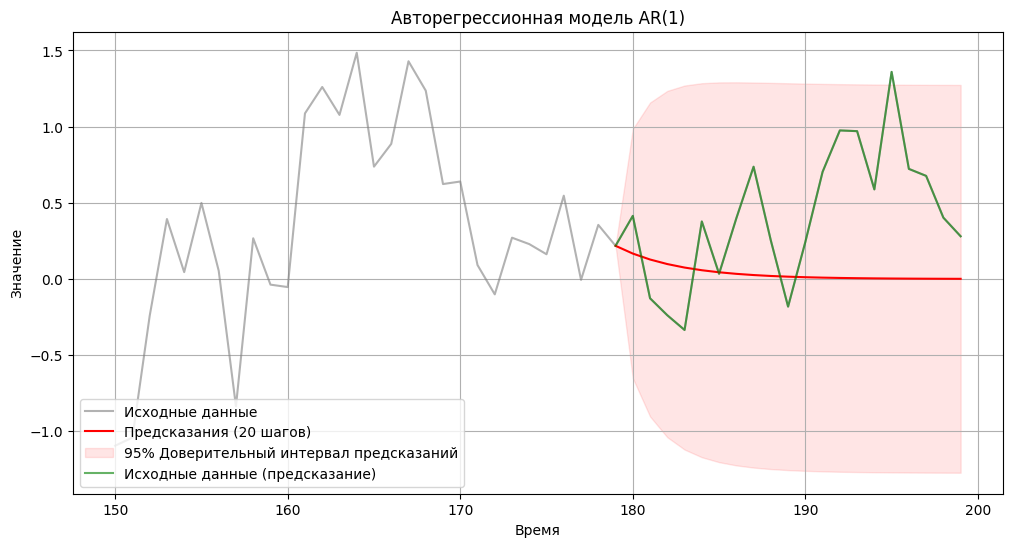

In [ ]:
### Пример использования класса

# 1. Создание и выборка данных
ar_p = 1
true_coefficients_no_intercept = np.array([0.8]) # [phi_1]
true_std_dev = 0.4

ar_model = AR_MLE(p=ar_p)
# Генерируем данные без константы
sample_data_no_intercept = ar_model.sample(coefficients=true_coefficients_no_intercept, length=200, std_dev=true_std_dev, initial_values=np.array([0.0])) # Начальное значение X_0 = 0

# 2. Обучение модели с использованием явных формул для AR(1) без константы
# Указываем n_predict, чтобы исключить последние точки из обучения
n_predict_example = 20
ar_model.fit(data=sample_data_no_intercept, n_predict=n_predict_example)

# 3. Построение графика с доверительным интервалом
ar_model.plot(confidence_level=0.95, start=150, end=220, n_predict=n_predict_example) # Пример среза, включающего предсказания

## Многомерная гауссовская выборка

Что если наблюдения -- векторы, но всё ещё независимые между друг другом? Для иллюстраций рассмотрим 2d, а формулы напишем в общем виде.

### Модель

### Правдоподобие

$X_{i} \sim^{iid} \mathcal{N}(\mu, \Sigma)$

Теперь в параметрах у нас вектор матожидания $\mu$ и ковариационная матрица $\Sigma$, но правдоподобие в силу независимости пишется точно так же.

$$
L(\theta) = p_{\theta}(x_1, ..., x_n) =  \prod \limits_{i=1}^n p_{\mathcal{N}(\mu, \Sigma)}(x_i)
$$


$$
l(\theta) = const - \frac{n}{2} \ln (\det \Sigma) - \frac{1}{2}\sum_{i=1}^n (x_i - \mu)^T \Sigma^{-1} (x_i - \mu).
$$

Для оценки параметров нам понадобится продифференцировать лог-правдоподобие по матрице и приравнять производные к нулю.

Квадратичные формы очень удобно представлять через след, который мы уже умеем дифференцировать:

$$
x^T Q x = \text{Tr} (Qx x^T).
$$

Считаем производную по $\mu$ (на доске), приравниваем к нулю и...

$$
\mu = \frac{1}{n}\sum_{i=1} x_i = \overline{x},
$$

что достаточно логично. В случае $\Sigma$ удобно воспользоваться свойством детерминанта

$$
det(A^{-1}) = 1/det(A)
$$

и дифференцировать по $\Sigma^{-1}$. Немного расчётов (см. доску) и...

$$
\Sigma = \frac{1}{n} \sum_{i=1}^n (X_i - \mu)(X_i - \mu)^T,
$$

где $\mu$ мы уже нашли ранее.

In [ ]:

class MultivariateNormalMLE:
    """
    Класс для многомерного нормального распределения с оценкой параметров MLE.
    """
    def __init__(self):
        self.mean = None
        self.covariance = None

    def sample(self, mean: np.ndarray, covariance: np.ndarray, n_samples: int) -> np.ndarray:
        """
        Генерирует выборку из многомерного нормального распределения.

        Args:
            mean (np.ndarray): Вектор среднего.
            covariance (np.ndarray): Ковариационная матрица.
            n_samples (int): Количество генерируемых выборок.

        Returns:
            np.ndarray: Сгенерированные выборки (n_samples, n_features).
        """
        return np.random.multivariate_normal(mean, covariance, size=n_samples)

    def fit(self, data: np.ndarray):
        """
        Оценивает параметры (среднее и ковариацию) методом MLE.

        Args:
            data (np.ndarray): Данные для обучения (n_samples, n_features).
        """
        # Проверка размера данных
        if data.ndim < 2:
            raise ValueError("Данные должны быть двумерным массивом (n_samples, n_features).")

        n_samples, n_features = data.shape

        # Оценка среднего
        self.mean = np.mean(data, axis=0)

        # Оценка ковариации (явный вид)
        # Формула для ММП оценки: Sigma = 1/n * sum((x_i - mu) * (x_i - mu).T)
        res = data - self.mean

        self.covariance =  np.einsum("ti,tj->ij",res,res) / n_samples
        #более простой вариант
        #self.covariance = (res.T @ res) / n_samples


        print("Оценка MLE завершена.")
        print(f"Оцененное среднее:\n{self.mean}")
        print(f"Оцененная ковариация:\n{self.covariance}")

    def plot(self, data: np.ndarray, confidence_level: float = 0.95):
        """
        Визуализирует данные и доверительный эллипс (только для 2D).

        Args:
            data (np.ndarray): Исходные данные.
            confidence_level (float): Уровень доверия для эллипса.
        """
        if self.mean is None or self.covariance is None:
            raise ValueError("Модель не обучена. Запустите метод `fit`.")

        if data.shape[1] != 2:
            print("Визуализация поддерживается только для 2D данных.")
            return

        plt.figure(figsize=(8, 8))
        plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Исходные данные')

        # Построение доверительного эллипса
        eigenvalues, eigenvectors = np.linalg.eigh(self.covariance)
        order = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[order]
        eigenvectors = eigenvectors[:, order]

        # Угол поворота эллипса
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

        # Квантиль для chi-squared распределения
        # df=2 для двумерного распределения
        chi_squared_val = scistats.chi2.ppf(confidence_level, df=2)

        # Длина полуосей
        width, height = 2 * np.sqrt(chi_squared_val) * np.sqrt(eigenvalues)

        from matplotlib.patches import Ellipse
        ellipse = Ellipse(xy=self.mean, width=width, height=height, angle=angle,
                          facecolor='none', edgecolor='red', lw=2, label=f'{int(confidence_level*100)}% Доверительный эллипс')

        ax = plt.gca()
        ax.add_patch(ellipse)

        # Центр распределения
        plt.plot(self.mean[0], self.mean[1], 'ro', label='Оцененное среднее')

        plt.title('Многомерное нормальное распределение')
        plt.xlabel('Переменная 1')
        plt.ylabel('Переменная 2')
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()


Оценка MLE завершена.
Оцененное среднее:
[1.98132649 3.01822901]
Оцененная ковариация:
[[0.96626953 0.74027629]
 [0.74027629 1.39293483]]


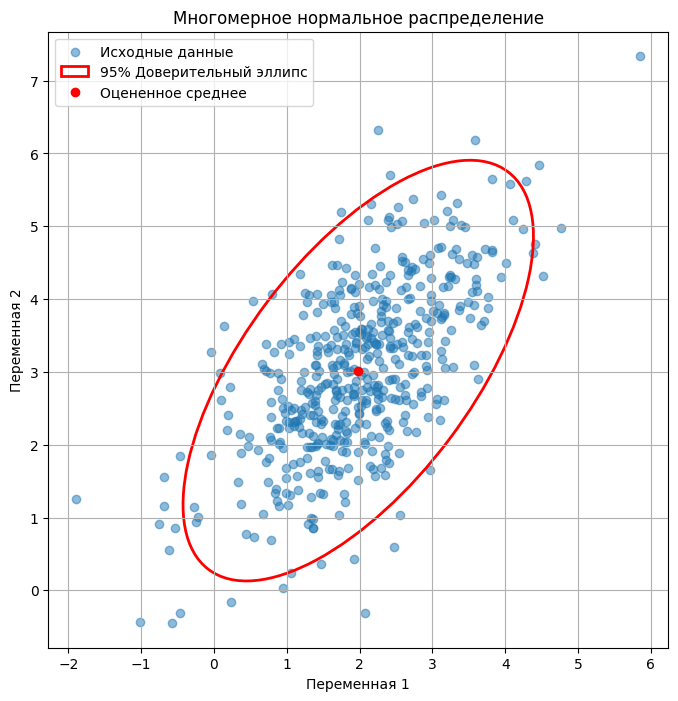

In [ ]:
### Пример использования класса

# 1. Создание экземпляра класса
mle_model = MultivariateNormalMLE()

# 2. Определение истинных параметров и генерация данных
true_mean = np.array([2, 3])
true_covariance = np.array([[1.0, 0.8],
                             [0.8, 1.5]])
n_samples = 500

sample_data = mle_model.sample(true_mean, true_covariance, n_samples)

# 3. Оценка параметров на основе сгенерированных данных
mle_model.fit(sample_data)

# 4. Визуализация данных и доверительного эллипса
mle_model.plot(sample_data, confidence_level=0.95)

## Векторная авторегрессия

Модель векторной авторегрессии, обозначаемая $VAR(p)$ -- это та же $AR(p)$, но теперь $X$ и $\varepsilon$ -- это векторы, а коэффициент перед лагом -- квадратная матрица $A$. До этого мы научились работать с зависимостями в правдоподобии, научились строить оценки для векторного гауссовского случая, теперь -- попробуем комбо.

### Модель

$X_0 = x_0 = const \in \mathbb{R}^d$

$X_{i+1} = A X_i + \epsilon_{i+1} $

$\epsilon_i \overset{iid}{\sim}  \mathcal{N}(0, \Sigma)$


### Правдоподобие

$X_{i+1} = A X_i + \epsilon_{i+1}, \quad X_{i+1} | X_i \sim \mathcal{N}(A X_i, \Sigma)$

В общем, всё то же, что мы уже видели, но теперь параметры сложнее:

$$
L(\theta) = p_{\theta}(x_1, ..., x_n) = p_{\theta}(x_1) p_{\theta}(x_2 | x_1) ... p_{\theta}(x_n | x_{n-1}, ... x_1)  = \prod \limits_{i=0}^{n-1} p_{\theta}(x_{i+1} | x_{i}) = \prod \limits_{i=0}^{n-1} p_{\mathcal{N}(A x_{i-1}, \Sigma)}(x_{i+1})
$$


$$
l(\theta) = const - \frac{n}{2} \ln (\det \Sigma) - \frac{1}{2}\sum_{i=0}^{n-1} (x_{i+1} - A x_{i})^T \Sigma^{-1} (x_{i+1} - A x_{i})
$$

Сразу видим, что приём с дифференцированием по $\Sigma^-1$ даёт нам уже известную формулу, н ов более сложной постановке:

$$
\Sigma = \frac{1}{n-1} \sum_{i=0}^{n-1} (x_{i+1} - Ax_i)(x_{i+1} - Ax_i)^T.
$$

Для дифференцирования по $A$ придётся расписать квадратичную форму чуть подробнее, так как там будут кросс-слагаемые.

$$
\frac{1}{2}\sum_{i=0}^{n-1} (x_{i+1} - A x_{i})^T \Sigma^{-1} (x_{i+1} - A x_{i}) =\frac{1}{2}\sum_{i=0}^{n-1} \text{Tr}\left( \Sigma^{-1}\left(x_{i+1}x_{i+1}^T + A x_{i} x_{i}^T A^T - A x_{i} x_{i+1}^T - x_{i+1} x_i^T A^T \right)\right)
$$

Под знаком суммы первое слагаемое не зависит от $A$. Второе слагаемое даёт после дифференцирования

$$
\frac{\partial \text{Tr}(\Sigma^{-1} Ax_ix_i^TA^T)}{\partial A^T} = ...\text{в этот момент загляните в лекцию, если не понимаете, как}... = 2x_ix_i^TA^T\Sigma^{-1},
$$

а третье и четвёртое -- это привычный уже след.

Собрав вместе и сократив справа на $\Sigma^{-1}$ получим из условия первого порядка

$$
A = \sum_{i=0}^{n-1} x_{i+1}x_{i}^T (\sum_{t=0}^{n-1} x_ix_i^T)^{-1}.
$$

Если говорить о вычислениях, можно поступить сильно проще. Вот как:
<details>
<summary>Спойлер</summary>
Может показаться странным, что мы выводим все эти формулы ведь это просто задача наименьших квадратов, которую нас учат решать через ```np.linalg.lstsq```. В поставленной нами задаче действительно так, но мы увидим, что это не всегда так удобно, как здесь.
</details>



In [ ]:
class VAR1_MLE:
    """
    Класс векторной авторегрессии (VAR(1)) с оценкой параметров
    методом максимального правдоподобия (MLE).
    """
    def __init__(self, K: int):
        """
        Инициализирует модель VAR(1) с заданным количеством переменных.

        Args:
            K (int): Количество временных рядов.
        """
        if K < 1:
            raise ValueError("Количество переменных K должно быть как минимум 1.")
        self.p = 1 # VAR(1)
        self.K = K  # Размерность временного ряда
        self.A = None # Матрица коэффициентов - будет оцениваться
        self.cov_matrix = None
        self.full_history = None # Полные исходные данные
        self.training_history = None # Данные, использованные для обучения
        self.fitted_data = None

    def sample(self, A: np.ndarray, length: int = 100, initial_values: np.ndarray = None, Sigma: np.ndarray = None) -> np.ndarray:
        """
        Генерирует выборку данных из модели VAR(1) с использованием заданной матрицы коэффициентов.

        Args:
            A (np.ndarray): Матрица коэффициентов (K, K).
            length (int): Длина сгенерированного временного ряда.
            initial_values (np.ndarray, optional): Начальные значения для ряда (K,).
                Если не предоставлены, используются случайные значения.
            Sigma (np.ndarray, optional): Ковариационная матрица шума.
                Если не предоставлена, используется единичная матрица.

        Returns:
            np.ndarray: Сгенерированный многомерный временной ряд (length, K).
        """
        if A.shape != (self.K, self.K):
            raise ValueError(f"Неверная форма матрицы коэффициентов A. Ожидается ({self.K}, {self.K}).")
        if Sigma is None:
            Sigma = np.eye(self.K)
        if Sigma.shape != (self.K, self.K):
            raise ValueError(f"Неверная форма ковариационной матрицы. Ожидается ({self.K}, {self.K}).")


        data = np.zeros((length, self.K))

        if initial_values is None:
            data[0] = np.random.multivariate_normal(np.zeros(self.K), Sigma)
        else:
            if len(initial_values) != self.K:
                 raise ValueError(f"Неверное количество начальных значений. Ожидается {self.K}.")
            data[0] = initial_values.copy()


        # Генерация остальных наблюдений
        for t in range(1, length):
            generated = A@data[t-1]
            noise = np.random.multivariate_normal(np.zeros_like(generated), Sigma)
            data[t] = generated + noise

        return data

    def fit(self, data: np.ndarray, n_predict: int = 0):
        """
        Оценивает матрицу коэффициентов A и ковариационную матрицу
        шума VAR(1) на основе предоставленных данных методом MLE.
        Обучение производится на первых len(data) - n_predict шагах.

        Args:
            data (np.ndarray): Временной ряд (length, K).
            n_predict (int): Количество шагов, которые будут использоваться для предсказания
                             и не будут включены в обучение.
        """
        if len(data) < 2 + n_predict:
            raise ValueError(f"Длина данных ({len(data)}) должна быть больше 1 + n_predict ({1 + n_predict}).")
        if data.shape[1] != self.K:
            raise ValueError(f"Размерность данных ({data.shape[1]}) не соответствует количеству переменных ({self.K}).")

        self.full_history = data.copy()
        training_data_length = len(data) - n_predict
        self.training_history = data[:training_data_length].copy()

        T = len(self.training_history)

        x_t = self.training_history[1:, :].T       # x_1, x_2, ..., x_{T-1}
        x_prev = self.training_history[:-1, :].T   # x_0, x_1, ..., x_{T-2}

        sum1 = x_t@x_prev.T
        sum2 = np.linalg.inv(x_prev@x_prev.T)
        # Оценка матрицы A
        try:
            self.A = sum1@sum2
        except np.linalg.LinAlgError:
            raise ValueError("Невозможно оценить матрицу A: сумма квадратов предыдущих значений вырождена.")


        # Оценка ковариационной матрицы шума Sigma

        residuals = x_t - (self.A@x_prev)

        sum_res_outer_prod = residuals @ residuals.T # Сумма outer произведений остатков
        num_observations = T - 1 # Количество наблюдений для расчета остатков
        self.cov_matrix = sum_res_outer_prod / num_observations

        print("Обучение VAR(1) завершено методом MLE (явные формулы, без константы).")
        print(f"Обучение проводилось на {training_data_length} точках.")
        print(f"Оцененная матрица коэффициентов A:\n{self.A}")
        print(f"Оцененная ковариационная матрица шума:\n{self.cov_matrix}")

        # Сохраняем подогнанные значения (для training_history)
        self._calculate_fitted_data(self.training_history)


    def _calculate_fitted_data(self, training_data: np.ndarray):
        """Вычисляет подогнанные значения на основе оцененных параметров для тренировочных данных."""
        if self.A is None:
             raise ValueError("Модель не обучена. Оцените параметры перед вычислением подогнанных значений.")

        n_obs = len(training_data)
        self.fitted_data = np.zeros((n_obs, self.K))
        # Первое значение подогнанного ряда равно историческому значению.
        self.fitted_data[0] = training_data[0]


        # Вычисление подогнанных значений для t >= 1
        for t in range(1, n_obs):
            predicted_value = self.A @ self.fitted_data[t - 1]
            self.fitted_data[t] = predicted_value


    def plot(self, confidence_level: float = 0.95, start: int = None, end: int = None, n_predict: int = 0):
        """
        Строит графики для каждого временного ряда с доверительными интервалами,
        включая предсказания.

        Args:
            confidence_level (float): Доверительная вероятность (от 0 до 1).
            start (int, optional): Начальный индекс для отрисовки.
            end (int, optional): Конечный индекс для отрисовки.
            n_predict (int): Количество шагов для предсказания. Должен быть равен n_predict,
                             использованному в методе fit.
        """
        if self.fitted_data is None or self.cov_matrix is None or \
           self.full_history is None or self.training_history is None:
            print("Модель не обучена должным образом. Убедитесь, что вы вызвали метод `fit`.")
            return

        total_length = len(self.full_history)
        training_length = len(self.training_history)

        if n_predict != total_length - training_length:
             print(f"Предупреждение: n_predict ({n_predict}) в plot не совпадает с количеством точек вне обучения ({total_length - training_length}).")

        plot_end_total = total_length + n_predict

        if start is None:
            plot_start_idx = 0
        else:
            plot_start_idx = max(0, start)

        if end is None:
            plot_end_idx = plot_end_total
        else:
            plot_end_idx = min(plot_end_total, end)

        if plot_start_idx >= plot_end_idx:
            print("Некорректный срез: начальный индекс больше или равен конечному.")
            return

        z_score = norm.ppf(1 - (1 - confidence_level) / 2)

        fig, axs = plt.subplots(self.K, 1, figsize=(12, 6 * self.K), sharex=True)
        if self.K == 1:
            axs = [axs]

        # --- Отрисовка исходных данных (полная история) ---
        history_plot_start = max(plot_start_idx, 0)
        history_plot_end = min(plot_end_idx, total_length)
        if history_plot_start < history_plot_end:
            for i in range(self.K):
                axs[i].plot(range(history_plot_start, history_plot_end),
                            self.full_history[history_plot_start:history_plot_end, i],
                            label=f'Исходные данные (Переменная {i+1})', color='gray', alpha=0.6)

        # --- Предсказания ---
        if n_predict > 0:
            last_observed_values = self.training_history[-1] # K-мерный вектор
            predictions = [last_observed_values] # Список K-мерных векторов (начинается с последнего наблюдаемого)

            # Расчет ковариаций ошибки предсказания для каждого шага h:
            # Var(y_{t+h}|y_t) = Sigma_h = Sigma + A Sigma A^T + A^2 Sigma (A^2)^T + ... + A^{h-1} Sigma (A^{h-1})^T
            # Sigma_h = sum_{j=0}^{h-1} (A^j) Sigma (A^j)^T
            forecast_covariances = np.zeros((n_predict + 1, self.K, self.K))
            forecast_covariances[0] = np.zeros((self.K, self.K)) # Дисперсия на шаге 0 (последнее наблюдение) равна 0

            A_power_j = np.eye(self.K) # A^0
            for h in range(1, n_predict + 1):
                # Предсказываем следующий шаг
                next_prediction = self.A @ predictions[-1]
                predictions.append(next_prediction)

                # Обновляем ковариацию ошибки предсказания
                forecast_covariances[h] = forecast_covariances[h-1] + A_power_j @ self.cov_matrix @ A_power_j.T
                A_power_j = self.A @ A_power_j # A^j -> A^(j+1)

            predictions_array = np.array(predictions) # (n_predict + 1, K)

            # Определяем диапазон отрисовки предсказаний
            # Предсказания начинаются с (training_length - 1) в полном ряду (включая последнее наблюдаемое)
            plot_prediction_start = max(plot_start_idx, training_length - 1)
            plot_prediction_end = min(plot_end_idx, training_length + n_predict)

            if plot_prediction_start < plot_prediction_end:
                # Индексы для среза predictions_array относительно начала предсказаний (training_length - 1)
                predictions_slice_start_idx = plot_prediction_start - (training_length - 1)
                predictions_slice_end_idx = predictions_slice_start_idx + (plot_prediction_end - plot_prediction_start)

                for i in range(self.K):
                    axs[i].plot(range(plot_prediction_start, plot_prediction_end),
                                predictions_array[predictions_slice_start_idx : predictions_slice_end_idx, i],
                                label=f'Предсказания ({n_predict} шагов) (Переменная {i+1})', color='red', linestyle='-')

                    # Вычисляем доверительный интервал для предсказаний
                    # Стандартные отклонения берутся из диагональных элементов ковариационной матрицы предсказания
                    forecast_std_devs = np.sqrt(np.array([np.diag(fcov)[i] for fcov in forecast_covariances[predictions_slice_start_idx : predictions_slice_end_idx]]))
                    lower_bound_pred = predictions_array[predictions_slice_start_idx : predictions_slice_end_idx, i] - z_score * forecast_std_devs
                    upper_bound_pred = predictions_array[predictions_slice_start_idx : predictions_slice_end_idx, i] + z_score * forecast_std_devs

                    axs[i].fill_between(range(plot_prediction_start, plot_prediction_end),
                                         lower_bound_pred, upper_bound_pred,
                                         color='red', alpha=0.1, label=f'{int(confidence_level*100)}% Доверительный интервал предсказаний')

                # Отрисовываем исходные данные (часть, которая сравнивается с предсказаниями)
                # Этот участок исходных данных находится после training_length - 1
                history_prediction_start = max(plot_start_idx, training_length - 1) # Начало участка сравнения в полном ряду
                history_prediction_end = min(plot_end_idx, total_length) # Конец участка сравнения в полном ряду


                if history_prediction_start < history_prediction_end: # Проверяем, что есть исторические данные в этом диапазоне
                    for i in range(self.K):
                        axs[i].plot(range(history_prediction_start, history_prediction_end),
                                    self.full_history[history_prediction_start:history_prediction_end, i],
                                    label=f'Исходные данные (предсказание) (Переменная {i+1})', color='green', alpha=0.6)

        for i in range(self.K):
            axs[i].set_title(f'Переменная {i+1}')
            axs[i].set_ylabel('Значение')
            axs[i].legend()
            axs[i].grid(True)

        plt.suptitle(f'Векторная авторегрессионная модель VAR({self.p}) с MLE (без константы)')
        plt.xlabel('Время')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

Обучение VAR(1) завершено методом MLE (явные формулы, без константы).
Обучение проводилось на 180 точках.
Оцененная матрица коэффициентов A:
[[ 0.6084912   0.29419771]
 [-0.0786923   0.44504875]]
Оцененная ковариационная матрица шума:
[[0.90346862 0.47399438]
 [0.47399438 1.76205881]]


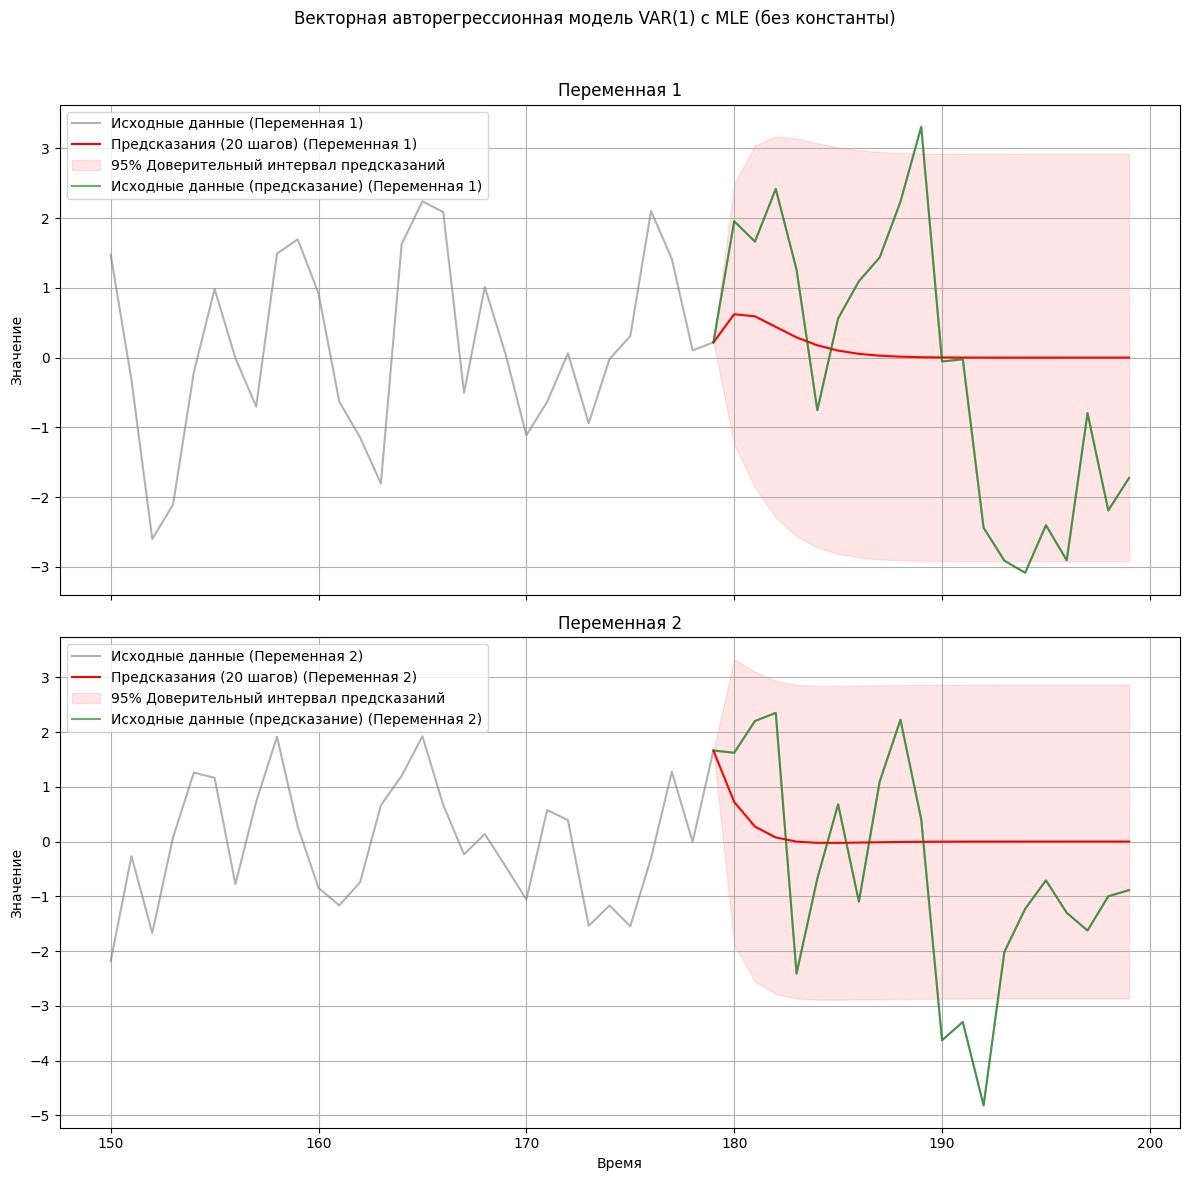

In [ ]:
# --- Пример использования ---

# 1. Создание экземпляра класса с заданным количеством переменных
K_dim = 2
var1_model = VAR1_MLE(K=K_dim)

# Истинные параметры для генерации данных
true_A = np.array([[0.6, 0.3],
                    [-0.1, 0.5]])
true_cov_matrix = np.array([[1.0, 0.5],
                             [0.5, 2.0]])

length = 200
n_predict_example = 20 # Количество шагов для предсказания

# Генерируем данные для новой модели
sample_data = var1_model.sample(
    A=true_A,
    length=length,
    Sigma=true_cov_matrix
)

# 2. Обучение модели (оценка A, и ковариации)
var1_model.fit(data=sample_data, n_predict=n_predict_example)

# 3. Построение графика
var1_model.plot(confidence_level=0.95, n_predict=n_predict_example, start=150, end=220)


### Модель маятника

Рассмотрим модель математического маятника (это модель малый колебаний, без нелинейных эффектов физического маятника).

В непрерывном времени через законы Ньютона и предполагая $\sin x \approx x$ (так как малые колебания) мы можем получить такое уравнение:

$$
\ddot{x}=-w^2 x,
$$

где две точки обозначают вторую производную, $x$ -- угловое отклонение маятника от положения равновесия (в радианах), $\omega^2$ -- коэффициент, определяющий частоту колебаний. Это дифференциальное уравнение. Оно сводится к системе двух уравнений первого порядка вводом новой переменной $v$:

$$
\dot{x} = v, \quad \dot{v} = - \omega^2 x.
$$

Мы полагаем известными начальное положение $x(0)=x_0$ И начальную скорость $v(0)=v_0$.

Если дискретизировать его по времени (например, методом Эйлера), то мы получим с учётом неопределённости ошибок метода (которые мы моделируем гауссовскими шумами) следующую систему уравнений:

$$ \left\{\begin{array}{l} x_{n+1}=x_{n} + v_n \Delta t+\varepsilon_{n+1}, \quad \varepsilon_{n+1} \sim \mathcal{N}\left(0, {\sigma_{x}}^2\right) \\ v_{n+1}=v_n -\omega^2 x_n \Delta t+\eta_{n+1}, \quad \eta_{n+1} \sim \mathcal{N}(0, {\sigma_{v}}^2) \end{array}\right.$$

Если мы наблюдаем $x_i,~v_i$, то по этим данным мы можем попробовать оценить параметры маятника. Вообще это в точности модель $VAR(1)$ со своей специфичной структурой:

$$
X_i = \begin{bmatrix} x_i \\ v_i\end{bmatrix}, \quad A = \begin{bmatrix} 1 & \Delta t\\ -\omega^2 \Delta t & 1\end{bmatrix}, \quad \Sigma = \begin{bmatrix} \sigma^2_x & 0\\0 & \sigma^2_v\end{bmatrix}
$$

Мы попробуем её оценить с помощью общего класса $VAR(1)$ и с использованием знания о структуре.

Видно, что численный метод несовершенен, потому что закон сохранения энергии не выполняется. Как это можно заметить из матрицы $A$?

Обучение VAR(1) завершено методом MLE (явные формулы, без константы).
Обучение проводилось на 180 точках.
Оцененная матрица коэффициентов A:
[[ 1.          0.05      ]
 [-0.00765769  1.00080827]]
Оцененная ковариационная матрица шума:
[[ 2.18695716e-16 -6.73973418e-11]
 [-6.73973418e-11  2.19737956e-03]]


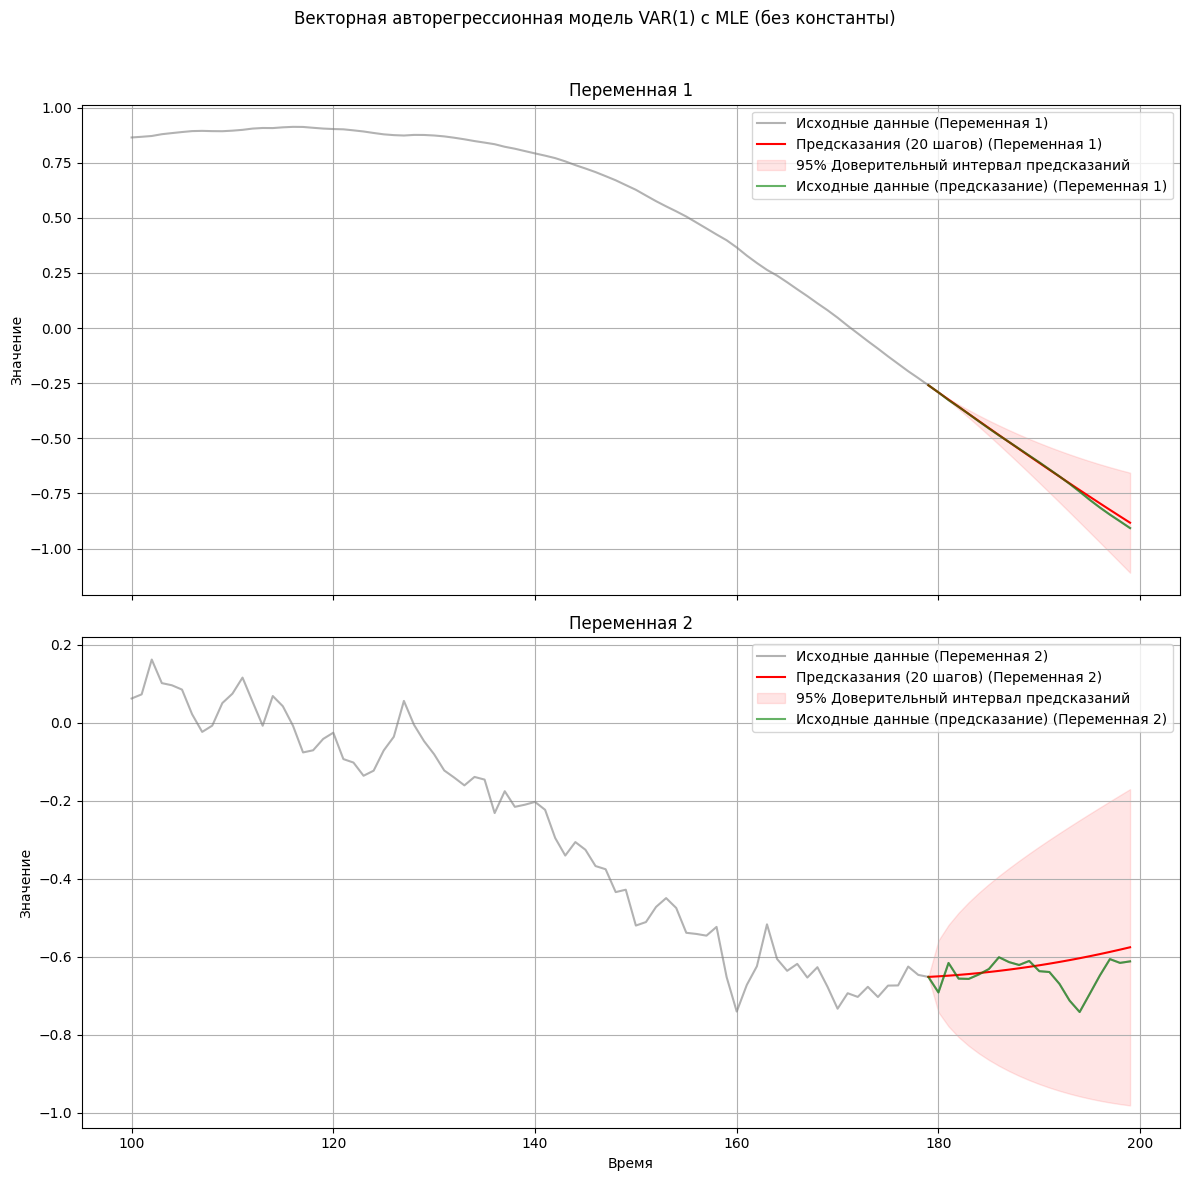

In [ ]:
# --- Пример использования VAR(1)---

# 1. Создание экземпляра класса с заданным количеством переменных
K_dim = 2
var1_model = VAR1_MLE(K=K_dim)

# Истинные параметры для генерации данных
# 1. Создание и выборка данных
true_omega = 0.4
dt = 5e-2
true_sigma_x2 = np.sqrt(dt)*1e-15 #полагаем, что шумов в x нет -- в механике это было бы сродни телепортации
true_sigma_v2 = np.sqrt(dt)*1e-2 #ветер?..
x0 = 0.2
v0 = 0.0
true_A = np.array([[1., dt],
                    [-true_omega**2*dt, 1.]])
true_cov_matrix = np.array([[true_sigma_x2, 1e-20],
                             [1e-20, true_sigma_v2]])

initial_values=np.array([x0,v0])
length = 200
n_predict_example = 20 # Количество шагов для предсказания

# Генерируем данные для новой модели (с константой и A)
sample_data = var1_model.sample(
    A=true_A,
    initial_values=initial_values,
    length=length,
    Sigma=true_cov_matrix
)

# 2. Обучение модели (оценка A, константы и ковариации)
var1_model.fit(data=sample_data, n_predict=n_predict_example)

# 3. Построение графика
var1_model.plot(confidence_level=0.95, n_predict=n_predict_example, start=100, end=200)